# Training a Neural Fields to Represent Image

In this colab, you are going to do a small coding exercise where you will train a neural network to represent an image.

In [ ]:
!pip install imageio-ffmpeg
!pip install lovely-tensors

# TODO isntall what you need

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lovely_tensors as lt
import os, imageio
import numpy as np
import torch
lt.monkey_patch()

# TODO import what you need

# Data

Our data will be pairs of $(x, y)$, where $x\in \mathbb{R}^2$ parameterize the pixel location, and $y\in \mathbb{R}^3$ is the RGB.

In this section, we will write a pytorch dataloader to produce these pairs.

<ipython-input-5-134d0b79aeca>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3]


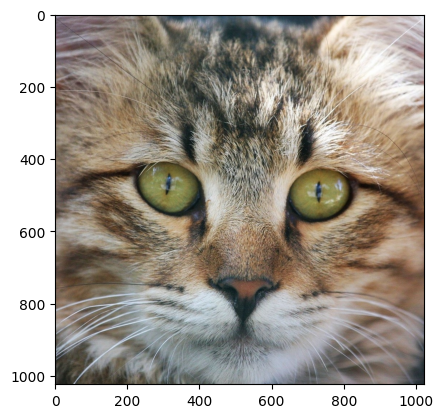

In [ ]:
# Download image, take a square crop from the center
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
plt.imshow(img)
plt.show()

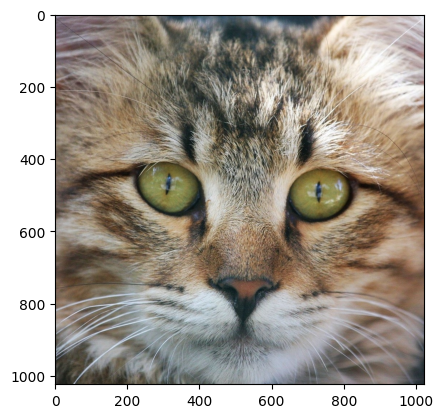

In [ ]:
plt.imshow(torch.from_numpy(img).view(-1, 3).view(1024, 1024, 3))

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader

def get_img_tensor(img, sidelength):
    transform = Compose([
        ToTensor(),
        Resize(sidelength),
        # Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

class CustomImageDataset(Dataset):
    def __init__(self, img, sidelength=1024):
        super().__init__()
        img = get_img_tensor(img, sidelength)
        self.X = get_mgrid(sidelength, 2) # TODO: (..., 2)
        self.Y = img.permute(1, 2, 0).view(-1, 3) # TODO: (..., 3)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# TODO test your dataset
dataset = CustomImageDataset(img, 1024)
print(dataset.X.shape)
print(dataset.Y.shape)
loader = DataLoader(dataset, batch_size=1024)
xy, rgb = next(iter(loader))
xy, rgb
print(rgb.type())
print(rgb)
print(xy.type())
print(xy)


torch.Size([1048576, 2])
torch.Size([1048576, 3])
torch.FloatTensor
tensor[1024, 3] n=3072 (12Kb) x∈[0.114, 0.933] μ=0.442 σ=0.213
torch.FloatTensor
tensor[1024, 2] n=2048 (8Kb) x∈[-1.000, 1.000] μ=-0.500 σ=0.646


# Network Architecture


Tips: you might find it useful to use Fourier positional encoding helpful! Check these papers:
1. https://arxiv.org/abs/2006.09661
2. https://arxiv.org/abs/2006.10739
3. https://arxiv.org/abs/2003.08934



In [ ]:
class SineActivation(nn.Module):
    # https://colab.research.google.com/drive/1gSr_DzMSCO5eNriPS_9FCL2fSWSiruq3#scrollTo=bsW62jqilZYz

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

tensor[4] x∈[1.000, 1.000] μ=1.000 σ=0. [1.000, 1.000, 1.000, 1.000]

In [ ]:
import torch.nn as nn

std = 10
freqs = 128
B = torch.randn((2, freqs)) * std

def pos_enc(x, *args, **kwargs):
  if len(x.shape) == 1:
    x = x.unsqueeze(0)

  # From [batchsize, xdim] to [batchsize, freqs]
  x = 2 * np.pi * (x @ B)

  # Positional encoding using sin and cos functions, [batchsize, freqs*2]
  enc = torch.cat([torch.cos(x),
                  torch.sin(x)], dim=1)
  return enc

print(pos_enc(torch.ones(4, 2)).shape)

class Net(nn.Module):

  def __init__(self,
               inp_dim=2, out_dim=3, hid_dims=[128],
               activation='relu',
               first_omega_0=30,
               hidden_omega_0=30,
               **kwargs):
    super().__init__()
    layers = []

    curr_dim = inp_dim

    act = get_activation(activation)

    for dim in hid_dims:
      linear = nn.Linear(curr_dim, dim)
      with torch.no_grad():
        if curr_dim == inp_dim:
          linear.weight.uniform_(-1 / inp_dim,
                                   1 / inp_dim)
          act = get_activation(activation, first_omega_0)
        else:
          linear.weight.uniform_(-np.sqrt(6 / curr_dim) / hidden_omega_0,
                                np.sqrt(6 / curr_dim) / hidden_omega_0)
          act = get_activation(activation, hidden_omega_0)

      layers.append(linear)
      layers.append(act)
      curr_dim = dim

    final_linear = nn.Linear(curr_dim, out_dim)
    with torch.no_grad():
        final_linear.weight.uniform_(-np.sqrt(6 / curr_dim) / hidden_omega_0,
                                      np.sqrt(6 / curr_dim) / hidden_omega_0)

    layers.append(final_linear)

    self.net = nn.Sequential(*layers)

  def get_activation(self, activation, omega=0):
    if activation == 'sine':
      return lambda x: torch.sin(omega * x)

    activations = nn.ModuleDict({
        'relu': nn.ReLU(),
        'leakyrelu': nn.LeakyReLU(),
    })
    return activations[activation]

  def forward(self, x):
    # TODO: pass parameters to positional encoding
    # x = pos_enc(x)
    return self.net(x)
    # for layer in self.layers:
    #   x = self.nonlin(layer(x))
    # return self.out(x)

torch.Size([4, 256])


In [ ]:
# Test your architecture
net = Net(2, 3, [256, 256, 256, 256], 'leakyrelu').cuda()
batch_size = 1234
net(torch.ones((batch_size, 2)).cuda())

tensor[1234, 3] n=3702 (14Kb) x∈[0.003, 0.048] μ=0.020 σ=0.020 grad AddmmBackward0 cuda:0

In [ ]:
net

In [ ]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        im = get_img_tensor(img, sidelength)
        self.pixels = im.permute(1, 2, 0).view(-1, 3)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        return self.coords[idx], self.pixels[idx]

In [ ]:
dataset = ImageFitting(256)


# Training

<ipython-input-13-ff0a029be53e>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3]


Step 0, total loss 0.33236610889434814
Step 100, total loss 0.026984479278326035
Step 200, total loss 0.02566235512495041
Step 300, total loss 0.024579836055636406
Step 400, total loss 0.02292017638683319
Step 500, total loss 0.023891938850283623
Step 600, total loss 0.025070026516914368
Step 700, total loss 0.022335698828101158
Step 800, total loss 0.022549152374267578
Step 900, total loss 0.022212687879800797
Step 1000, total loss 0.0197564959526062
Step 1100, total loss 0.020420631393790245
Step 1200, total loss 0.018439454957842827
Step 1300, total loss 0.019230632111430168
Step 1400, total loss 0.019793201237916946
Step 1500, total loss 0.01797192543745041
Step 1600, total loss 0.017399422824382782
Step 1700, total loss 0.018021589145064354
Step 1800, total loss 0.017290806397795677
Step 1900, total loss 0.01748756133019924
Step 2000, total loss 0.017970364540815353
Step 2100, total loss 0.017292551696300507
Step 2200, total loss 0.017556868493556976
Step 2300, total loss 0.016236

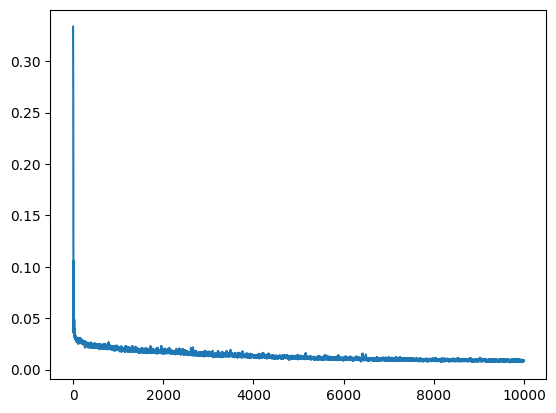

In [ ]:
# Preparing training, (e.g. initialize optimizer ...)
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
dataset = CustomImageDataset(img, 1024)
loader = DataLoader(dataset, batch_size=1024,
                    shuffle=True, pin_memory=True, num_workers=0)

net = Net(2, 3, [256, 256, 256, 256], 'leakyrelu')
net.cuda()

total_steps = 10000
summary_steps = 100

opt = torch.optim.Adam(lr=1e-3, params=net.parameters())

data_iter = iter(loader)

loss_list = []
for i in range(total_steps):
  try:
    x, y = next(data_iter)
  except StopIteration:
    # StopIteration is thrown if dataset ends
    # reinitialize data loader
    data_iter = iter(loader)
    x, y = next(data_iter)
  x, y = x.cuda(), y.cuda()

  opt.zero_grad()
  out = net(x)
  loss = nn.MSELoss()(out, y)
  with torch.no_grad():
      loss_list.append(loss.item())
      if i % summary_steps == 0:
        print(f'Step {i}, total loss {loss.item()}')

  loss.backward()
  opt.step()

  # TODO: monitor the training.
plt.plot(loss_list)
plt.show()

# Testing

In [ ]:
def create_image(resolution):
  input = get_mgrid(resolution, 2).cuda()
  rgb = net(input)
  rgb = rgb.reshape(resolution, resolution, 3)
  return rgb.detach().cpu().numpy()

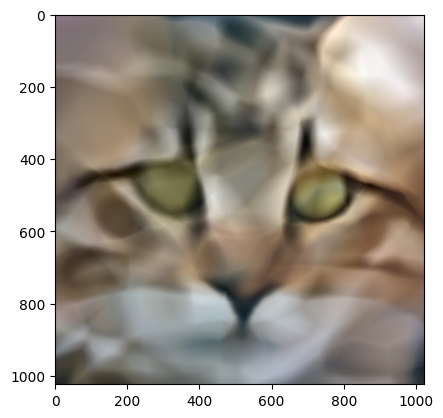

In [ ]:
plt.imshow(create_image(1024))
plt.show()

In [ ]:

out_img = create_image(1024*8)
plt.imshow(out_img)
plt.show()

# Some open questions

- Does the network know the face is symmetry?
- What would you do to enforce the network outputs symmetry signals?